In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from os import path
from scipy.cluster.vq import kmeans2
import subprocess
import time
from gpflow import set_trainable
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
import arviz as az
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib

assert tf.__version__ >= "2.1.0"

from gp4gw.sample import SampleLogJoint
import gp4gw.bbh_example as bbh_example
from gp4gw.data_preparation import *
from gp4gw.training_tools import *
from gp4gw.deep_kernel import DeepKernel

# Make plots inline
%matplotlib inline

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
import corner

In [4]:
# import warnings

# warnings.filterwarnings("ignore")

# gpflow.config.set_default_float(np.float64)
# np.random.seed(0)
# tf.random.set_seed(0)

In [5]:
import warnings

warnings.filterwarnings("ignore")
import os
aPath = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11/'
os.environ['XLA_FLAGS'] = aPath

os.environ['CUDA_VISIBLE_DEVICES']='0'

In [6]:
%load_ext autoreload
%autoreload 2

# Load and prepare samples
The posterior samples used are taken from [GWTC-1 Original bilby result files](https://dcc.ligo.org/LIGO-P2000193/public). This file contains hundreds of thousands of samples, so we only load a small percentage of it to not incurr into memory errors. I checked on the prior files that this run had distance, phase and time marginalised.

In [7]:
data_path='/home/virginia.demilio/bilby_results_files/GW150914_data0_1126259462-391_analysis_H1L1_dynesty_merge_result.json'

In [8]:
import bilby
bb = bilby.result.read_in_result(data_path)

In [9]:
assert bb.meta_data['command_line_args']['distance_marginalization'] ==True
assert bb.meta_data['command_line_args']['phase_marginalization']==True
assert bb.meta_data['command_line_args']['time_marginalization']==True

In [10]:
list(bb.priors.keys())[:20]

['chirp_mass',
 'mass_ratio',
 'mass_1',
 'mass_2',
 'a_1',
 'a_2',
 'tilt_1',
 'tilt_2',
 'phi_12',
 'phi_jl',
 'luminosity_distance',
 'theta_jn',
 'psi',
 'phase',
 'azimuth',
 'zenith',
 'H1_time',
 'recalib_H1_amplitude_0',
 'recalib_H1_amplitude_1',
 'recalib_H1_amplitude_2']

In [11]:
param_names = ['chirp_mass','mass_ratio','a_1','a_2','tilt_1','tilt_2','phi_12','phi_jl',
                'theta_jn','psi','azimuth','zenith']

assert len(param_names) == 12

In [12]:
all_priors = param_names + ['mass_1', 'mass_2']

In [13]:
analytic_priors = {key: bb.priors[key] for key in all_priors}

In [14]:
my_data = scale_data(
    **bbh_example.load_data(
        path=data_path, param_names=param_names, samples_frac=0.2
    )
)
parameters_scaler = my_data["x_scaler"]
likelihood_scaler = my_data["y_scaler"]

X = tf.convert_to_tensor(my_data["x_train"], dtype=tf.float64)
Y = tf.convert_to_tensor(my_data["y_train"].reshape(-1, 1), dtype=tf.float64)

N, Q = X.shape
print(f'X_train shape: {N}, {Q}; Y_train shape: {Y.shape}')

Shape of x-data: N=47692, Q=12
X_train shape: 47692, 12; Y_train shape: (47692, 1)


2021-12-06 10:04:37.368093: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-06 10:04:37.368467: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-06 10:04:37.370011: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Build GP model

This part needs to run with TensorFlow GPU, unless the model has already been constructed, i.e. the model directory is present.

In [15]:
periodic_dims = [param_names.index('azimuth'),
                 param_names.index('phi_12'),
                 param_names.index('phi_jl'),
#                  param_names.index('phase'),
                 param_names.index('psi')]

In [16]:
Q

12

In [17]:
k1 = gpflow.kernels.SquaredExponential(lengthscales=[0.1]*Q , variance=1.0)

k4 = gpflow.kernels.Matern12(lengthscales=[0.1]*Q , variance=1.0)

k3 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(
    active_dims=periodic_dims, lengthscales = 0.1, variance=1.0))

kernel = DeepKernel(
    Q, Q,  k1*k4*k3
)

In [18]:
M = 800 # number of inducing points

In [19]:
Z = kmeans2(X.numpy(), M, minit="points")[0]
model = gpflow.models.SGPR(
   (X, Y), kernel, inducing_variable=Z, mean_function=gpflow.mean_functions.Constant(min(Y)-10), noise_variance=1.1e-5
)

In [20]:
set_trainable(model.mean_function, True)

2021-12-06 10:04:41.414468: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [21]:
adam_learning_rate=0.1
lr_schedule=True

In [22]:
nepochs=100

In [23]:
if lr_schedule:
    lr = InverseTimeDecay(
        adam_learning_rate,
        decay_steps=int(nepochs / 4),
        decay_rate=1,
        staircase=False)
else:
    lr = adam_learning_rate

start_time = time.time()
model_logdir = "../models/model_GW150914_M800_N100_128_128_128/"
step_var = tf.Variable(1, dtype=tf.int32, trainable=False)
epoch_var = tf.Variable(1, dtype=tf.int32, trainable=False)
ckpt = tf.train.Checkpoint(model=model, step=step_var, epoch=epoch_var)
manager = tf.train.CheckpointManager(ckpt, model_logdir, max_to_keep=5)
if path.exists(model_logdir + "checkpoint"):
    print(f"Loading model from folder path {model_logdir}")
    ckpt.restore(manager.latest_checkpoint)
else:
    print(f"Checkpoint folder path at: {model_logdir}")
    checkpointing_training_loop_exact_GP(
        model,
        X = X,
        Y = Y,
        optimizer=tf.keras.optimizers.Adam(lr),
        epochs=nepochs,
        manager=manager,
        epoch_var=epoch_var)
    print("--- Training took %s minutes ---" % ((time.time() - start_time) / 60))
print(
    f"Training error: {mean_squared_error(Y, model.predict_y(X)[0])}"
)

Loading model from folder path ../models/model_GW150914_M800_N100_128_128_128/
Training error: 0.458131569510337


In [24]:
kernel

name,class,transform,prior,trainable,shape,dtype,value
DeepKernel.base_kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.8164275926402423
DeepKernel.base_kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(12,)",float64,"[0.10918503, 0.10804725, 0.10887634..."
DeepKernel.base_kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.8164275926402422
DeepKernel.base_kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(12,)",float64,"[0.11336089, 0.11030584, 0.11200827..."
DeepKernel.base_kernel.kernels[2].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.816427592640242
DeepKernel.base_kernel.kernels[2].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.10861813036659322
DeepKernel.base_kernel.kernels[2].period,Parameter,Softplus,,True,(),float64,1.0558842049244501
DeepKernel.feature_extractor._layers[1]._trainable_weights[0] DeepKernel.feature_extractor._layers[1].kernel,ResourceVariable,,,True,"(12, 128)",float64,"[[-0.15618318, -0.09891219, 0.05853085..."
DeepKernel.feature_extractor._layers[1]._trainable_weights[1] DeepKernel.feature_extractor._layers[1].bias,ResourceVariable,,,True,"(128,)",float64,"[-0.04048717, 0.00250745, -0.03706433..."
DeepKernel.feature_extractor._layers[2]._trainable_weights[0] DeepKernel.feature_extractor._layers[2].kernel,ResourceVariable,,,True,"(128, 128)",float64,"[[0.06579737, -0.14670358, -0.10469685..."


In [25]:
mean, cov = model.predict_y(X)

In [26]:
print('Test MAE: {}'.format(np.mean(np.abs(mean - Y))))

Test MAE: 0.5167655507930872


# MAE for a series of different Kernel architectures

**128 nodes**
5 layers = 0.67
4 layers = 0.51
3 layers = 0.52
2 layers = 0.53

**single layer**
1024 nodes = 16.82
256 nodes = 0.52
128 nodes = 0.51
32 nodes = 0.55

# Sampling the Likelihood surrogate

Change the kernel to regular TensorFlow on CPU to run this part.

In [27]:
X_scaled = my_data['x_scaler'].inverse_transform(my_data['x_train'])

In [28]:
mcmc_points = 5000
num_burnin = mcmc_points * 0.5
num_chains = 10
initialise_chains = np.mean(X, axis=0)

In [29]:
quick_priors = bbh_example.quick_priors(X_scaled, param_names, analytic_priors)

Loading non-scaled priors bounds


In [30]:
quick_priors

{'chirp_mass': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>,
 'mass_ratio': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>,
 'a_1': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>,
 'a_2': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>,
 'tilt_1': <gp4gw.bbh_example.tf_Sine at 0x7f7f16d09b80>,
 'tilt_2': <gp4gw.bbh_example.tf_Sine at 0x7f7ffd7e1400>,
 'phi_12': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>,
 'phi_jl': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>,
 'theta_jn': <gp4gw.bbh_example.tf_Sine at 0x7f7f16ceff10>,
 'psi': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>,
 'azimuth': <tfp.distributions.Uniform 'Uniform' batch_shape=[] event_shape=[] dtype=float64>,
 'zenith': <gp4gw.bbh_example.tf_Sine at 0x7f7f16cefbb0>,
 'mass_1': <gp

In [31]:
sample = SampleLogJoint(
    predict_log_joint_mean_var=model.predict_f,
    analytic_priors=quick_priors,
    param_names=param_names,
    parameters_scaler=my_data['x_scaler'],
    log_joint_scaler=my_data['y_scaler'],
)

In [32]:
print(f'mcmc_points: {mcmc_points}, num_burnin: {int(num_burnin)}')
start_time = time.time()
print("Running chain..")
all_samples = sample.run_chain(
    num_results=mcmc_points,
    num_burnin_steps=int(num_burnin),
    initialise_chains=initialise_chains + 1e-3 * np.random.randn(num_chains, X.shape[1]),
    num_chains=num_chains,
    sampler='HMC',
)
print("--- Sampling took %s minutes ---" % ((time.time() - start_time) / 60))

mcmc_points: 5000, num_burnin: 2500
Running chain..
Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
Running sampler with SimpleStepSizeAdaptation


2021-12-06 10:05:09.916974: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3700000000 Hz
2021-12-06 10:05:09.918257: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b04411aa50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-06 10:05:09.918311: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-06 10:05:10.183114: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:241] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired.
2021-12-06 10:05:33.314112: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


--- Sampling took 13.15297208627065 minutes ---


In [33]:
combine_chains = np.zeros((mcmc_points * num_chains, len(param_names)))
for i in range(len(param_names)):
    combine_chains[:, i] = all_samples[:, :, i].numpy().flatten()
gp_samples = my_data['x_scaler'].inverse_transform(combine_chains)

In [34]:
az_data = convert_to_arviz_data(all_samples, my_data['x_scaler'], param_names)

In [35]:
az.summary(az_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chirp_mass,30.793,1.139,28.655,32.980,0.030,0.021,1424.0,1253.0,1.01
mass_ratio,0.830,0.119,0.618,1.000,0.005,0.003,810.0,611.0,1.01
a_1,0.437,0.253,0.000,0.825,0.011,0.008,446.0,345.0,1.02
a_2,0.415,0.251,0.000,0.814,0.013,0.009,308.0,197.0,1.02
tilt_1,1.628,0.682,0.414,2.855,0.021,0.015,985.0,1067.0,1.01
tilt_2,1.687,0.669,0.499,2.885,0.021,0.015,957.0,813.0,1.01
phi_12,2.952,1.784,0.043,5.856,0.088,0.062,356.0,393.0,1.03
phi_jl,2.675,1.941,0.001,5.881,0.158,0.112,140.0,186.0,1.06
theta_jn,2.160,0.687,0.905,3.112,0.035,0.025,446.0,837.0,1.03
psi,1.540,0.923,0.006,2.950,0.042,0.029,449.0,435.0,1.02


In [36]:
latex_names = {
    'chirp_mass': r'$\mathcal{M}$',
    'mass_ratio': r'q',
    'a_1': r'$a_1$',
    'a_2': r'$a_2$',
    'luminosity_distance': r'$d_{L}$',
    'phase': r'$\phi$',
    'psi': r'$\psi$',
    'dec': r'dec',
    'ra': r'ra',
    'cos_theta_jn': r'$cos(\theta_{jn})$',
    'azimuth': r'azimuth',
    'zenith': r'zenith',
    'theta_jn': r'$\theta_{jn}$',
    'tilt_1':r'$t_1$',
    'tilt_2':r'$t_2$',
    'a_1':r'$a_1$',
    'a_2':r'$a_2$',
    'phi_12':r'$\phi_{12}$',
    'phi_jl':r'$\phi_{jl}$',
    'geocent_time':r'$t_c$'
              }

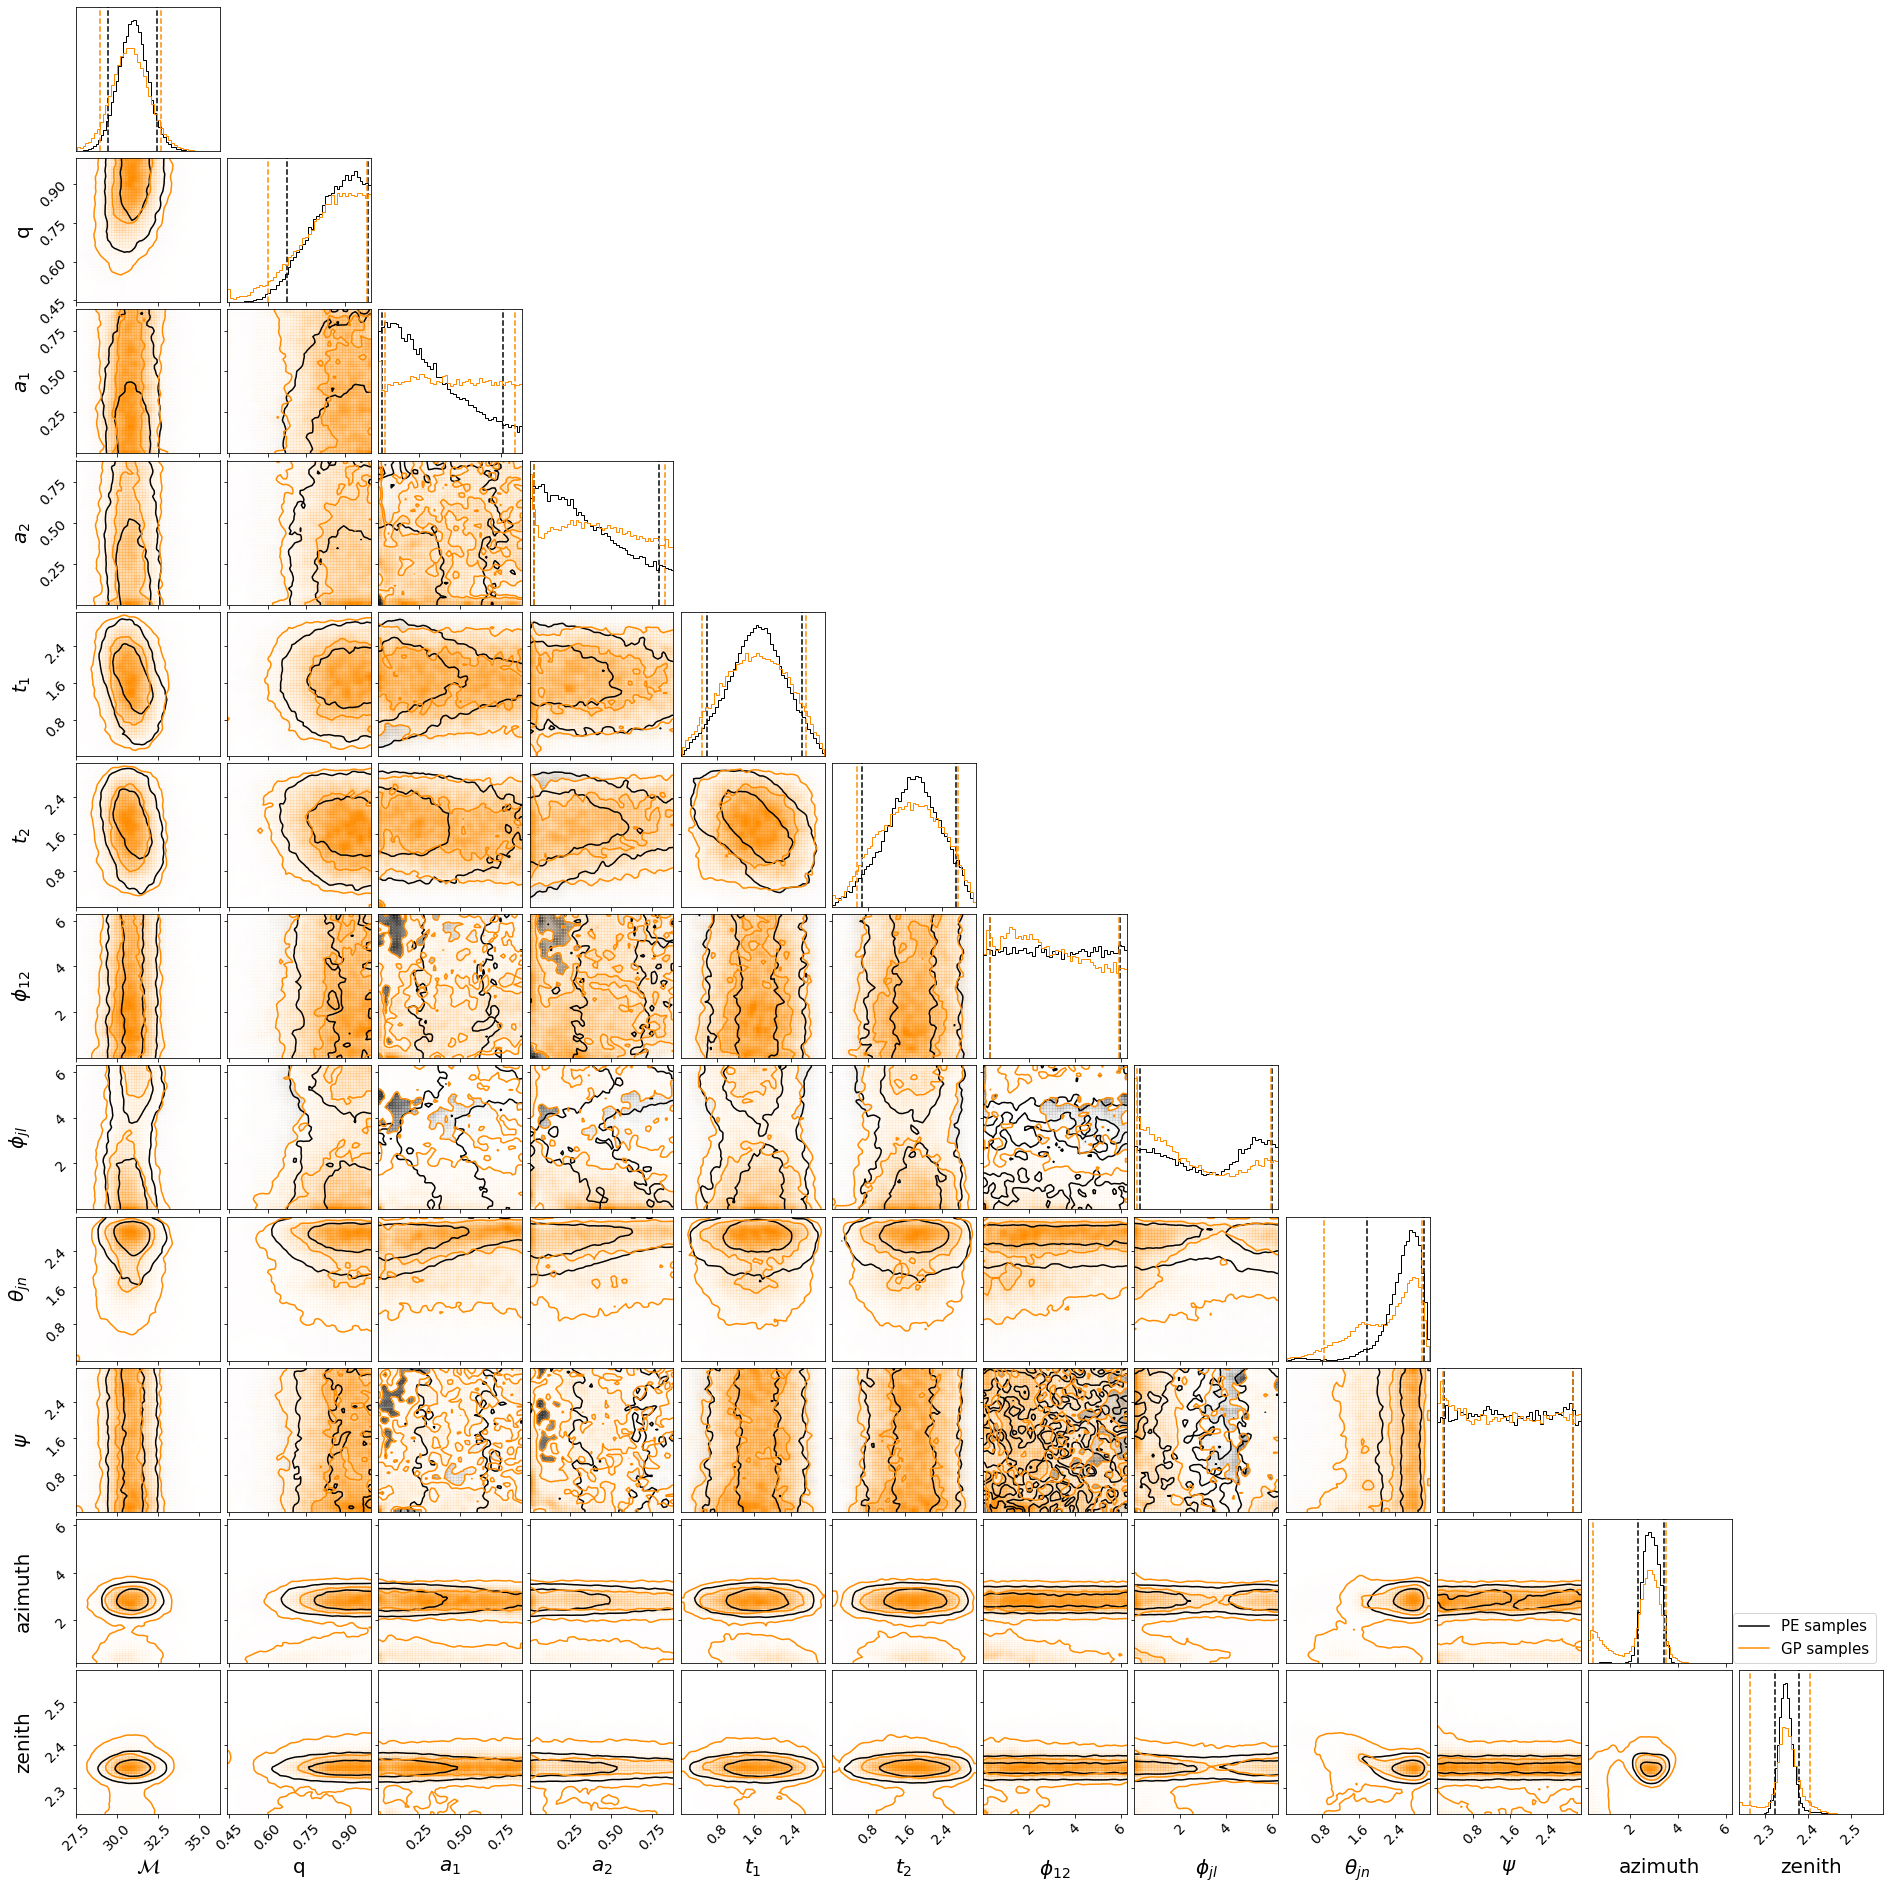

In [37]:
blue_line = matplotlib.lines.Line2D([], [], color="k", label="PE samples")
red_line = matplotlib.lines.Line2D([], [], color="darkorange", label="GP samples")
fig1 = corner.corner(
    parameters_scaler.inverse_transform(my_data['x_train']),
    bins=50,
    labels=[latex_names[key] for key in param_names],
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color="k",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

fig = corner.corner(
    gp_samples,
    fig=fig1,
    bins=50,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    labels=[latex_names[key] for key in param_names],
    color="darkorange",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

fig.get_axes()[4].tick_params(which="major", bottom=False)
fig.get_axes()[5].tick_params(which="both", bottom=False)
fig.get_axes()[8].tick_params(which="both", bottom=False)
fig.get_axes()[9].tick_params(which="both", bottom=False)
fig.get_axes()[9].tick_params(which="both", left=False)
fig.get_axes()[10].tick_params(which="both", bottom=False)
fig.get_axes()[13].tick_params(which="both", left=False)
fig.get_axes()[14].tick_params(which="both", left=False)
fig.get_axes()[0].tick_params(which="both", bottom=False)

for ax in fig.get_axes():
    ax.tick_params(axis="both", labelsize=14)

plt.legend(
    handles=[blue_line, red_line],
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc=4,
    fontsize=15,
)

# plt.savefig("GW150914_sumKplusPeerioidic.png")